<a href="https://colab.research.google.com/github/mpv88/DeepLearning2022/blob/main/Third_assignment_08012023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lorenzobasile/DeepLearning2022/blob/main/7_forward_forward.ipynb)

# Third assignment - 01/2023 - mattia pividori (s284690)


1.   Read Hinton's [paper](https://www.cs.toronto.edu/~hinton/FFA13.pdf) about the Forward Forward algorithm.
2.   Reproduce the experiment described at page 5 of the paper.
3.   Experiment with two of the following three points for future work reported in the paper and discuss your findings:
    * A) What is the best activation function to use? 
    * B) What is the best goodness function to use?
    * C) Can positive and negative passes be widely separated in time as they would be if the negative passes were done during sleep?


In [1]:
import torch
import torchvision
from google.colab import drive
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drive.mount('/content/drive')
%cd drive/MyDrive/DeepLearning2022

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DeepLearning2022


# The Forward Forward algorithm

The [Forward Forward algorithm](https://www.cs.toronto.edu/~hinton/FFA13.pdf) has been presented by Geoffrey Hinton (one of the "Deep Learning godfathers") at NeurIPS 2022, less than a month ago.

It is a novel technique for Neural Network optimization, alternative to standard Backpropagation.

Over the last decades, backprop has been so successful that neuroscientists have been looking for proofs that the brain actually learns in a similar way. However, that does not seem to happen. Moreover, backprop encounters serious limitations if the model is not exactly defined in mathematical terms: if the forward pass is a black box, there is no possibility to make a backward pass (as we don't know what to differentiate).

Even if (for the moment) it was not presented with the goal of substituting backprop for practical applications, the Forward Forward algorithm aims at solving some of these problems, using a layer-by-layer learning approach that does not require backward propagation of gradients.

## MNIST classification through FF

Let's see how FF works through a practical example on MNIST classification.

Citing the paper,  "the idea is to replace the forward and backward passes of backpropagation by two forward
passes that operate in exactly the same way as each other, but on different data and with opposite
objectives. The positive pass operates on real data and adjusts the weights to increase the goodness in
every hidden layer. The negative pass operates on "negative data" and adjusts the weights to decrease
the goodness in every hidden layer. This paper explores two different measures of goodness – the
sum of the squared neural activities and the negative sum of the squared activities, but many other
measures are possible."

Thus, we have to find a way to define "positive" and "negative" data. If we want to classify MNIST, a data point being positive means that it somehow contains the right assignment of an image to its corresponding class. Hence, we can define a positive datapoint by embedding the right classification into the image and a negative datapoint by embedding a random classification. To do so, we can exploit the fact that there is a black frame around the digit, and we can use the top 10 pixels on the left to embed class information.

![](https://github.com/lorenzobasile/DeepLearning2022/blob/main/images/ff_mnist.png?raw=1)

Then, the layers of the network are trained one at a time with the objective of assigning high activation values (high goodness) to positive points and low to negative ones. However, if there are many layers, it would be trivial for following layers to rely on the information coming from the previous ones (if the activations of layer $i$ are high, this drastically increases the probability that the activations of layer $i+1$ are high as well). To avoid this phenomenon and make layers learn different features, it is necessary to normalize the activation vector to have norm $1$.

At the end, at evaluation time, one can query the network with a certain image with all possible labels, and take the argmax of the goodnesses to obtain the prediction.

In [2]:
class Net(torch.nn.Module):
  def __init__(self, dimensions):
    super().__init__()
    self.layers = torch.nn.ModuleList([ReLULayer(dimensions[i], dimensions[i+1]) for i in range(len(dimensions)-1)])
  
  def predict(self, x):
    goodness_per_label = []
    for label in range(10):
      x_lab = label_images(x, label)
      goodness = []
      for i, layer in enumerate(self.layers):
        x_lab = layer(x_lab)
        if i > 0:
          goodness.append(pow(x_lab, 2).mean(dim=1, keepdim=False)) # Σ[relu(h)^2] .sum(dim=1, keepdim=False)
      goodness_per_label.append(sum(goodness).unsqueeze(1))
    goodness_per_label = torch.cat(goodness_per_label, 1)
    return torch.argmax(goodness_per_label, dim=1) # set to argmin for point 3.B
    
  def train(self, x_pos, x_neg):
    for layer in self.layers:
      x_pos, x_neg = layer.train(x_pos, x_neg)

In [3]:
def normalize(x):
  return torch.nn.functional.normalize(x, p=2.0, dim=1, eps=1e-12) #x/x.norm(p=2, dim=1, keepdim=True, dtype=torch.float) activation normalized by L2-norm to get direction only

class ReLULayer(torch.nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.linear = torch.nn.Linear(in_features, out_features)
    self.relu = torch.nn.ReLU() # ['torch.nn.ReLU()', 'torch.nn.LeakyReLU(0.25)', 'torch.nn.ELU(alpha=1.0)', 'torch.nn.CELU(alpha=1.0)', 'torch.nn.SELU()', 'torch.nn.GELU(approximate='none')', 'torch.nn.Threshold(threshold=0, value=-.5)', 'torch.nn.Sigmoid()', 'torch.nn.Tanh()', 'torch.nn.Softmax(dim=1)']
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.03)
    self.threshold = 2 # set to 0.5 for point 3.A
    self.num_epochs = 1000 # set to 2000 for point 3.C
    
  def forward(self, x):
    x_direction = normalize(x)
    return self.relu(self.linear(x_direction))

  def train(self, x_pos, x_neg):
    for i in range(self.num_epochs):
      #positive_goodness = torch.zeros(x_pos.size(dim=0)).to(device) # uncomment for point 3.C
      #negative_goodness = torch.zeros(x_neg.size(dim=0)).to(device) # uncomment for point 3.C
      positive_goodness = self.forward(x_pos).pow(2).mean(dim=1, keepdim=False) # positive goodness step .sum(dim=1, keepdim=False)
      negative_goodness = self.forward(x_neg).pow(2).mean(dim=1, keepdim=False) # negative goodness step .sum(dim=1, keepdim=False)
      l = torch.log(1 + torch.exp(torch.cat([-positive_goodness + self.threshold, # maximize positive goodness and viceversa
                                             +negative_goodness - self.threshold]))).mean() # minimize negative goodness and viceversa
      self.optimizer.zero_grad()
      l.backward(retain_graph=False)
      self.optimizer.step()
    return self.forward(x_pos).detach(), self.forward(x_neg).detach()

Train accuracy: 0.9306833148002625
Test accuracy: 0.9297999739646912


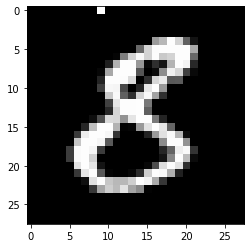

In [4]:
# instantiate neural net and fix seed
net = Net([784, 500, 500]).to(device)
torch.manual_seed(0)

# import normalized dataset to dataloaders
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,)), torchvision.transforms.Lambda(torch.flatten)])

trainset = torchvision.datasets.MNIST('./data/', transform=transform,  train=True, download=True)
testset = torchvision.datasets.MNIST('./data/', transform=transform, train=False, download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=60000, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

def label_images(images, labels):
  '''input are: (batch_size, 28x28) images and (batch_size, 1) labels 
     output is: (batch_size, 28x28) label-embedded images'''
  embedded_images = images.detach().clone() # in our case (60000x784)
  embedded_images[[ _ for _ in range(embedded_images.size(dim=0))], labels] = images.max(dim=1)[0]
  plt.imshow(embedded_images[1234].cpu().reshape(28,28), cmap='gray') # print sample embedded image
  return embedded_images

# unpack train set and create positive/negative samples 
x, y = next(iter(trainloader))
x = x.to(device)
y = y.to(device)

x_pos = label_images(x, y)
rnd = torch.randperm(x.size(0))
x_neg = label_images(x, y[rnd])

# launch training
net.train(x_pos, x_neg)
print('Train accuracy:', net.predict(x).eq(y).float().mean().item())

# unpack test set
x_test, y_test = next(iter(testloader))
x_test = x_test.to(device)
y_test = y_test.to(device)

# launch trained model on test set
print('Test accuracy:', net.predict(x_test).eq(y_test).float().mean().item())

The experiment outlined at page 5 of Hinton's paper, here approximated with Pytorch, leads to the following results: <br/>
Train accuracy: 0.933 and Test accuracy: 0.934 <br/>
with the small modification of using the mean of squared activations instead of their sum (outlined in paper).

To address the point 3.A we search if, ceteris paribus (so keeping constant all the other elements of our FF architecture), there is a specific activation function which is markedly better than the others (among the most common ones), namely:

* ReLU (nn.ReLU): train accuracy = 0.933, test accuracy = 0.934 [Baseline case]
* Leaky ReLU (nn.LeakyReLU(slope)), for different levels of slope parameter: 
      * slope=0.25, train accuracy = 0.902, test accuracy = 0.904
      * slope=0.50, train accuracy = 0.825, test accuracy = 0.823
      * slope=0.75, train accuracy = 0.743, test accuracy = 0.742

* Exponential Linear Unit (nn.ELU): train accuracy = 0.938, test accuracy = 0.937
* Continuously Differentiable Exponential Linear Unit (nn.CELU): train accuracy = 0.938, test accuracy = 0.937
* Scaled Exponential Linear Unit (nn.SELU): train accuracy = 0.911, test accuracy = 0.912
* Gaussian Error Linear Units (nn.GELU): train accuracy = 0.946, test accuracy = 0.943
* Threshold (nn.nn.Threshold): train accuracy = 0.944, test accuracy = 0.943  
<br/> (for the last three activation functions tested, we lowered the threshold from the default value of 2 to 0.5, so to allow the learning even for functions whose natural upper bound value is capped at 1)  <br/>
* Sigmoid (nn.Sigmoid): train accuracy = 0.173, test accuracy = 0.171
* Tanh (nn.Tanh): train accuracy = 0.265, test accuracy = 0.256
* Softmax (nn.Softmax(dim=1)): train accuracy = 0.099, test accuracy = 0.098

Among the activation functions tested, the GELU seems to lead to the best results.



    
    
    
 


In the second point (3.B), we would like to see if there is a goodness function to use which may be considered better than the others. Starting from what proposed in Hinton's paper at page 2 (see also Footnote 4), the base formulation examined is that of "[...] the sum of the squares of the activities
of the rectified linear neurons in that layer [...]", where as already mentioned, we replace the sum with the mean. Alternatively we may use the negative sum (mean) of the squared activities (which implies for the loss function to minimize the sum (or mean) squared activities for positive data and maximize it for negative data), or the unsquared activities (see page 15, Footnote 21) in both versions. <br/>

RESULTS: <br/>
The result using the negative mean of squared activities (thus looking for argmin) is slighly worse than the base case of point 2:<br/>
Train accuracy: 0.8965666890144348 and Test accuracy: 0.8944999575614929 <br/>

The result when minimizing the sum of unsquared activities for positive data (thus layer normalization must normalize the sum of the activities, not the sum of their squares) while maximizing the sum of unsquared activites for negative data is: <br/>
Train accuracy: 0.784416675567627 and Test accuracy: 0.779699981212616 <br/>

The result for maximizing the sum of unsquared activities for positive data and minimizing the sum of unsquared activites for negative data finally is: <br/>
Train accuracy: 0.4275333285331726 and Test accuracy: 0.43039998412132263

All the above results are obtained keeping a threshold level fixed to 2.


The third point (3.C) worth examining is if instead of executing at the same time both the positive and the negative passes, it would be equivalent (or at least not much worse) -in terms of overall accuracy- a wider separation in time between the two types of passes, ceteris paribus. This kind of alteration of the baseline running sequence -Hinton suggests- is intended to mimic more closely the sleep-wake cycle we observe into typical biological functioning, where the sleep phase would correspond to the 'negative' steps, while the wake phase to 'positive' ones.
We tried three alternatives in this regard, with increasing separation between the 2 states during the training relative to the one of the base case previously computed. Note that the overall n° of epochs has been doubled from 1000 to 2000 to cope with the alternative calculation of goodness measures.
1. 'small separation', alternating positive steps on even (odd) epochs and negative steps on odd (even) epochs, so to have a single epoch separation;
```
      if i==0 or (i%2)!=0:
        positive_goodness = self.forward(x_pos).pow(2).mean(dim=1, keepdim=False)
      else:
        negative_goodness = self.forward(x_neg).pow(2).mean(dim=1, keepdim=False)
```
2. 'medium separation', alternating positive and negative steps with frequency equal to 1/4 of the total number of epochs (i.e. about 500 epochs);
```
      if i<500 or (i>999 and i<1500):
        positive_goodness = self.forward(x_pos).pow(2).mean(dim=1, keepdim=False)
      else:
        negative_goodness = self.forward(x_neg).pow(2).mean(dim=1, keepdim=False)
```
3. 'large separation', alternating positive and negative steps with frequency equal to 1/2 of the total number of epochs (i.e. about 1000 epochs);
```
      if i<1000:
        positive_goodness = self.forward(x_pos).pow(2).mean(dim=1, keepdim=False)
      else:
        negative_goodness = self.forward(x_neg).pow(2).mean(dim=1, keepdim=False)
```

Our expectations, following the preliminary results showed in Fig. 5 of Hinton's paper, are that accuracy should be inversely related to the 2-passes separation (i.e. in the limit case of sleep deprivation, equal to the absence of negative steps in the model, the (biological) system is expected to fall apart).

RESULTS: <br/>
1. 'Small separation' with positive steps on even epochs and negative on odd ones are:<br/>
Train accuracy: 0.874 and Test accuracy: 0.882; <br/>
Note that if we start with a negative step instead, then results drop to 0.099 accuracy in training and 0.098 in testing.
2. 'Medium separation', with positive and negative steps with frequency 500 epochs: <br/> Train accuracy: 0.099 Test accuracy: 0.099.
3. 'Large separation', with positive and negative steps with frequency 1000 epochs: <br/> Train accuracy: 0.098 Test accuracy: 0.098.

What we notice is a marked degradation of model's performance already starting from point 2, meaning we have to focus on smaller degrees of separation, possibly starting from the one of point 1 and increasing the separation at a slower pace (i.e. in couples, in triples etc..). In any case, the performance observed at point 1 is coherent with our expectation of a result below the baseline case, but well above of a ZeroR classifier (about 10% accuracy).


